In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Function to draw image with caption
def plotImg(img, caption):
    plt.figure()
    plt.axis('off')
    ht = img.shape[0]+25
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)    
    plt.text(0,ht,caption)

# Load and return image in RGB space
def loadImage(fname):
    return mpimg.imread(fname)

OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository. The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).

OpenCV functions are used to calculate the camera matrix using the 19 JPEG images provided in the `camera_cal` folder. For each image, I collect get the chessboard corner points using `findChessboardCorners` function. These points are then passed to the `calibrateCamera` function that returns a `camera matrix` and an array of `distortion coefficients`.

Thee are then used to `undistort` images from the camera. See the effect of `undistortion` in the image below.

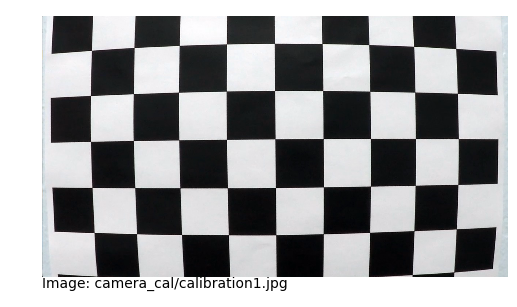

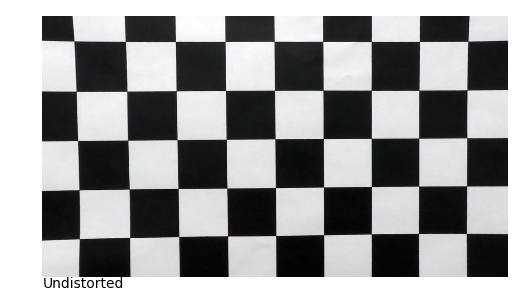

In [2]:
# Calibrate camera for distortion correction
def calibrateCamera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = loadImage(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return (mtx,dist)

mtx,dist = calibrateCamera()

fname='camera_cal/calibration1.jpg'
img = cv2.imread(fname)
undist = cv2.undistort(img, mtx, dist, None, mtx)

plotImg(img, "Image: {0}".format(fname))
plotImg(undist, "Undistorted")


Distortion Correction

Distortion correction that was calculated via camera calibration has been correctly applied to each image. An example of a distortion corrected image should be included in the writeup (or saved to a folder) and submitted with the project.



The `camera matrix` and `distortion coefficients` array are used to `undistort` a sample image. See the effect of `undistort` operaion in the images below.

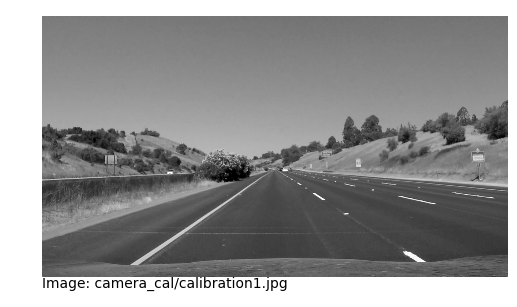

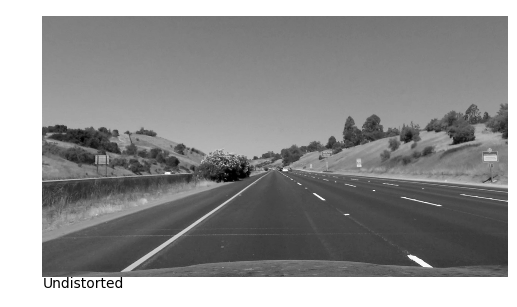

In [3]:
testImage = 'test_images/straight_lines1.jpg'
img = loadImage(testImage)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
undist = cv2.undistort(gray, mtx, dist, None, mtx)

plotImg(gray, "Image: {0}".format(fname))
plotImg(undist, "Undistorted")

Color and Gradient Tresholds

Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.

Goal: to isolate pixels that make up lane lines.

First I convert the color image to HLS and HSV formats to extract the `lightness` channel from HLS image and the `saturation` channel from the HSV.

Then I take the derivatives on the L Channel along x and y axes.

These derivative values are used to compute gradient magnitude and direction.

Pixels are then filtered to retain only areas where:
(i) direction values are within (0.6, 1.4)
(ii) and magnitude values are within (30, 100) 
(iii) and the derivative along x-axis lies within (20, 100).

Similarly, the S channel are filtered to retain only areas where the raw values lie between (170, 255).

Filtered output from these two are merged into a single binary frame.

The L-channel and S-channel each extract parts of the lane and together provide a complete image of the lanes.

The above tresholds were determined over several trials using the test images provided. 


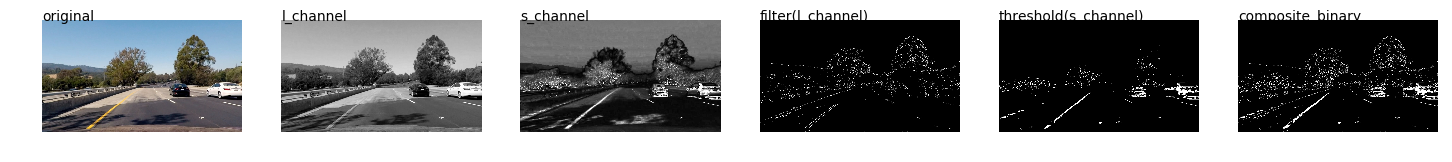

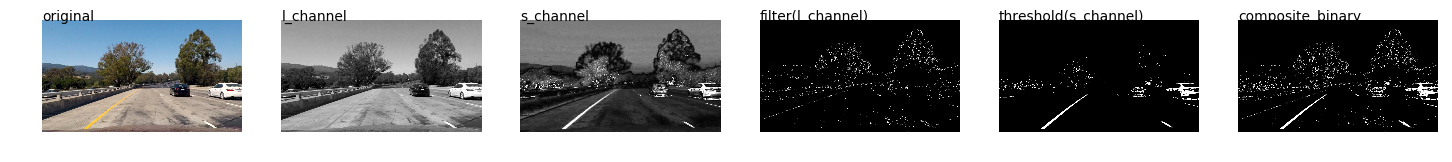

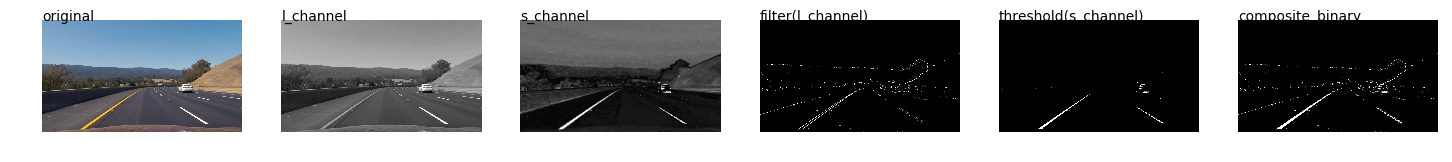

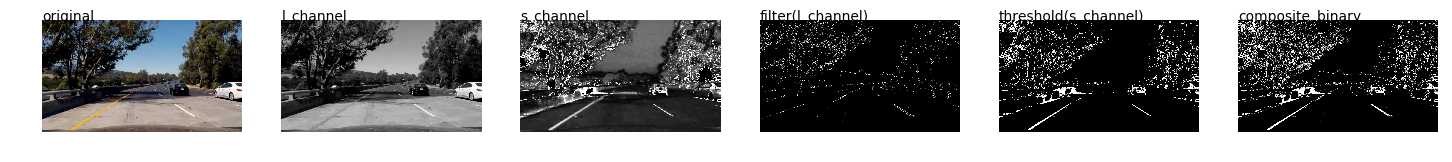

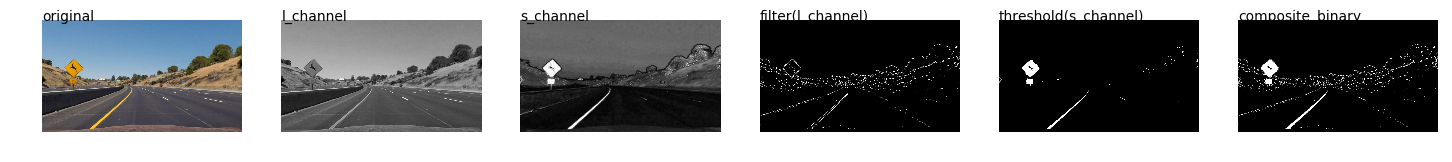

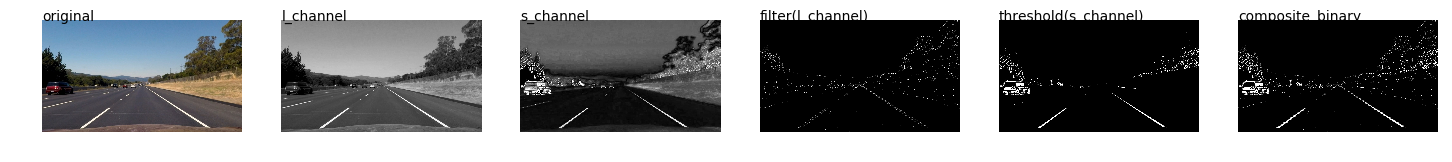

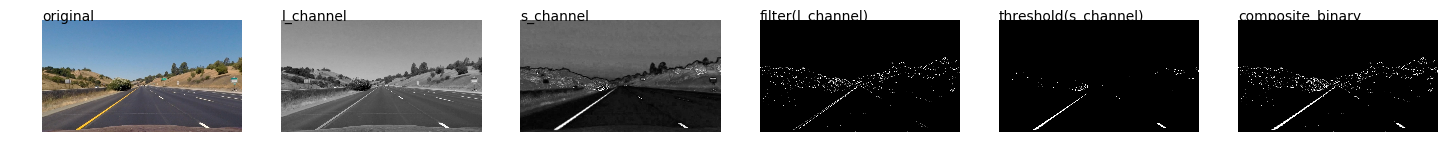

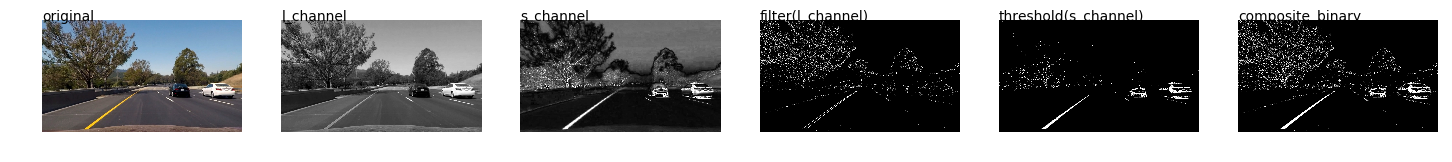

In [4]:
imgNo = 1
figNo = 1
def plotSubImage(img, caption):
    global imgNo
    plt.subplot(5, 6, imgNo)
    imgNo += 1
    plt.axis('off')

    scaledShape=(28, int(28.0*img.shape[1] / img.shape[0]))
    if len(img.shape) == 2:
        plt.imshow(img, shape=scaledShape, cmap='gray')
    else:
        plt.imshow(img, shape=scaledShape)
        
    plt.text(0, 0, caption, fontsize=10)

# produce a binary image with lane edges extracted
# return binary image
def extractLaneEdges(img, s_thresh=(170, 255), sx_thresh=(20, 100), mag_thresh=(30,100), dir_thresh=(0.6,1.4), visual=False):
    global figNo, imgNo

    # Convert to HLS color space and separate the L, S channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    #s_channel = hls[:,:,2]
    
    # Convert to HSV color space and separate the S, V channels
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    s_channel = hls[:,:,2]

    # Sobel x & y
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Calculate magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = (255 * mag / np.max(mag)).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    #mask_mag = np.zeros_like(scaled_mag)
    #mask_mag[ (scaled_mag>=mag_thresh[0]) & (scaled_mag<=mag_thresh[1]) ] = 1
    
    # Calculate direction
    arctan = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a binary mask where direction thresholds are met
    #mask_dir = np.zeros_like(arctan)
    #mask_dir[ (arctan>=dir_thresh[0]) & (arctan<=dir_thresh[1]) ] = 1

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[
        (scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])
        & (scaled_mag>=mag_thresh[0]) & (scaled_mag<=mag_thresh[1])
        & (arctan>=dir_thresh[0]) & (arctan<=dir_thresh[1])
            ] = 1

    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    composite_binary = np.zeros_like(s_binary)
    composite_binary[ (s_binary == 1) | (sxbinary==1)  ] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    if visual:
        imgNo = 1
        fig = plt.figure(figNo, (18.,15.))
        figNo += 1
        plotSubImage(img, "original")
        plotSubImage(l_channel,"l_channel")
        plotSubImage(s_channel,"s_channel")
        plotSubImage(sxbinary,"filter(l_channel)")
        plotSubImage(s_binary,"threshold(s_channel)")
        plotSubImage(composite_binary,"composite_binary")

    return composite_binary

images = glob.glob('test_images/*.jpg')

for fname in images:
    img = loadImage(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    result = extractLaneEdges(undist, visual=True)


Perspective Transform

Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". Transformed images should be included in the writeup (or saved to a folder) and submitted with the project.


## Perspetive transform for a bird's eye view

OpenCV's `perspectiveTransform` function is used to derive a bird's eye view of the lanes.
Undistorted images are transformed using a predetermined source and destination array of points.

The source coordinates are corners of the lane in 'test_images/straight_lines1.jpg'. 
The destination points were selected to make the lane appear vertial.

After `perspectiveTransform` is done, the lane lines near the top appear broken. To keep them together, I applied a dialation operation on the image using OpenCV's `dilate` function.


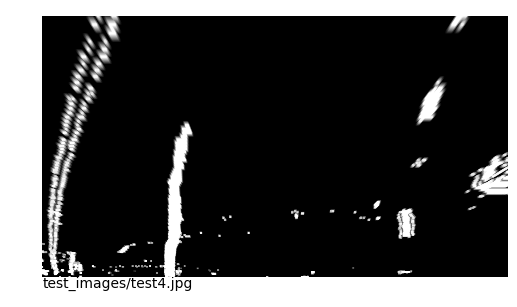

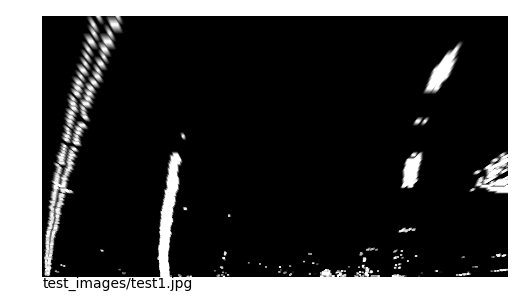

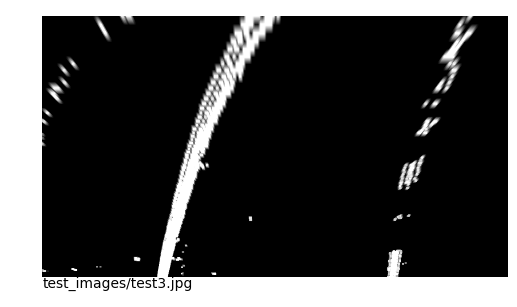

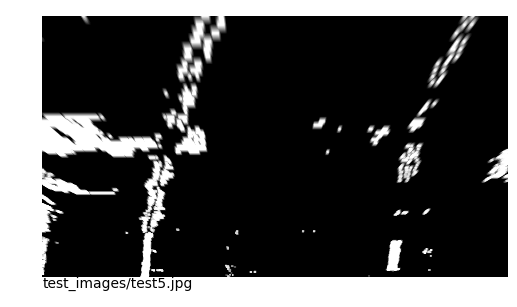

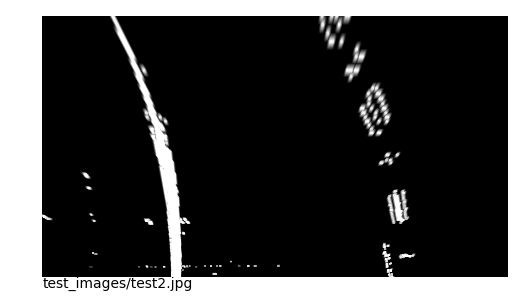

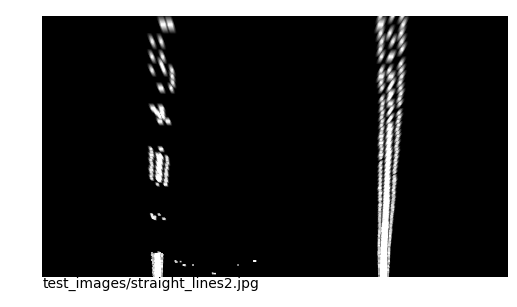

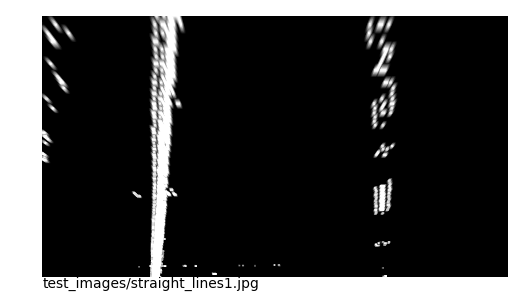

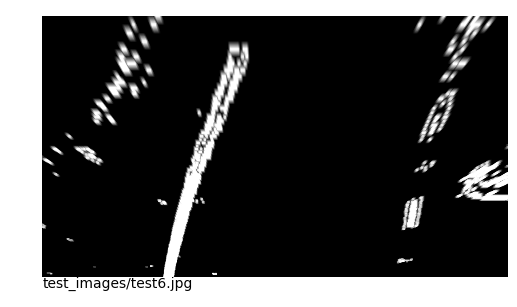

In [5]:
#src=np.array([(274,664),(613,437),(664,437),(1032,664)], dtype=np.float32)
src=np.array([(288,656), (590,450), (687,450), (1022,656)], dtype=np.float32)
dst=np.array([(300,720),(300,0),(950,0),(950,720)], dtype=np.float32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

# Do undistort and perspectiveTransform and store results in data dictionary
def birdsEyeView(img, data):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    data['undistortedImage'] = undist
    result = extractLaneEdges(undist)
    warped = cv2.warpPerspective(result, M, (result.shape[1], result.shape[0]), flags=cv2.INTER_LINEAR)
    warped = cv2.dilate(warped,kernel,iterations = 1)
    data['birdsEyeViewImage'] = warped

for fname in images:
    img = loadImage(fname)
    data = {}
    birdsEyeView(img, data)
    plotImg(data['birdsEyeViewImage'],fname)

Polynomial fitting

Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?
Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

## Lane line detection

### Tracing lane lines
Function `traceLineEdges` implements lane line tracing using sliding window method.
 - **Locate first window**
   - Compute a histogram along the y axis for only the bottom half of the image.\
   - Find largest peak to the left and right of center
   - Use x value of peak as center of window
   - y value of first window is set to the bottom of the image (720)
   
 - **Trace lane line**
   - Compute histogram within window
   - Locate the outer edges of the lane line
   - Calculate the center of the lane line
   - Slide window to the lane line's center
   - Move window up and repeat process

 - **Fitting polynomial**
   - Every window location is added to a collection
   - Using numpy fitPoly method a 2nd degree polynomial is fit to the points in the collection

### Lane line tracking
Once a polynomial is known, every frame need not be scanned from scratch. Instead, the polynomial can be adjusted using points within a small margin around the fitted line.
Function `continueLaneFit` implements this update method.


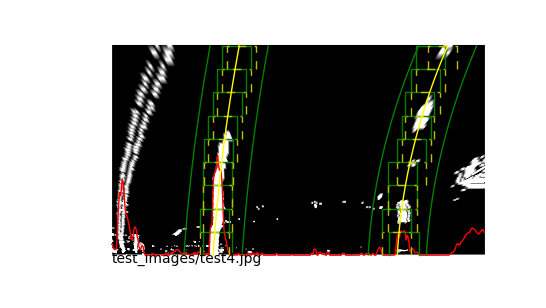

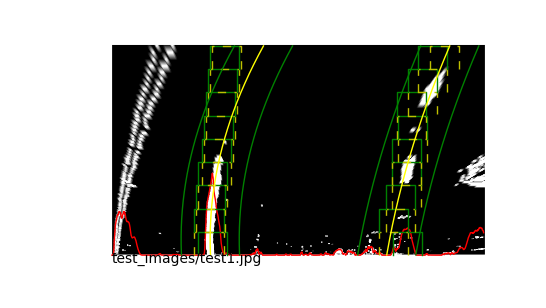

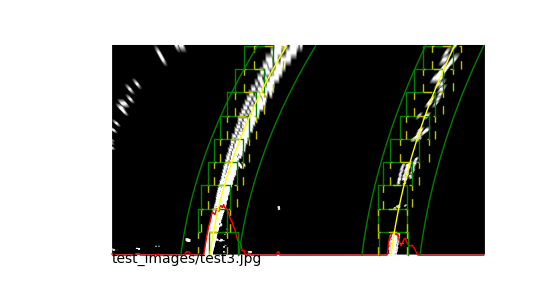

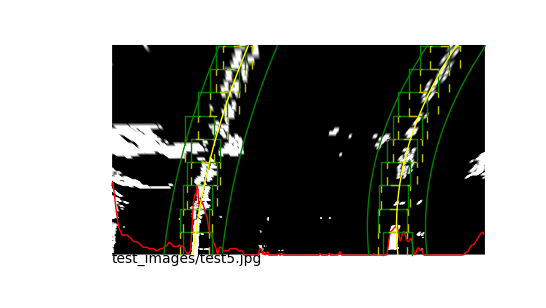

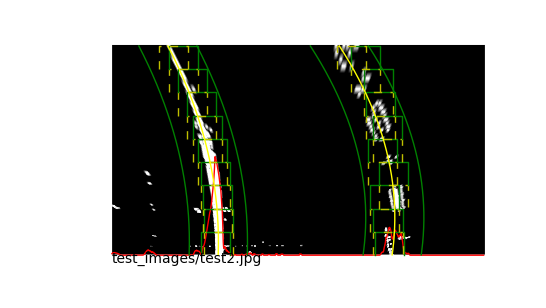

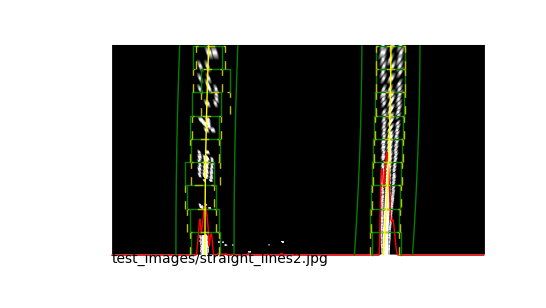

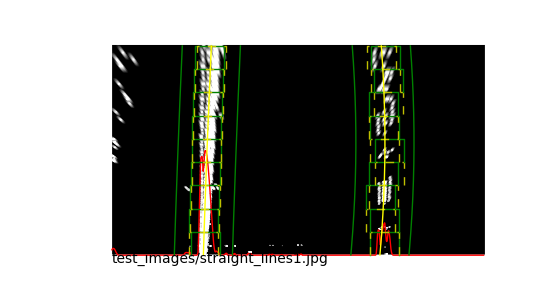

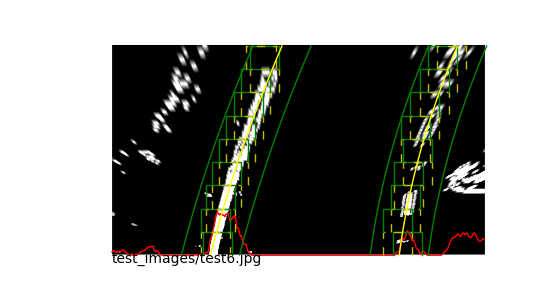

In [11]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# trace one lane line using sliding window method
# return fitted polynomial and polynomial scaled to real world scale
def traceLaneEdge(img, x, scale=(xm_per_pix, ym_per_pix), visualize=False):
    imgHeight = img.shape[0]
    zoneht = imgHeight // 9
    zonewd = 100
    delta = 0
    arrX = []
    arrY = []
    
    for y in range(imgHeight, 0, -zoneht):
        left = x - (zonewd // 2)
        right = x + (zonewd // 2)
        top = y - zoneht
        bottom = y
        if visualize:
            plt.plot([ left, left, right, right ], 
                     [ bottom, top, top, bottom ], 
                     'g-' )
            #print("(%d,%d) - (%d,%d)"%(left,top,right,bottom))

        hist = np.sum(img[top:bottom, left:right], axis=0).astype(np.uint8)
        #print("Histo {0} {1}".format(hist.shape, hist))
        
        blob = np.argwhere( hist > 20 )
        if len(blob) > 0:
            mid = int(np.median(blob))
            delta = (mid - (zonewd//2))
            #print(blob, mid, delta)
        else:
            mid = np.argmax(hist)
            if hist[mid] > 0:
                delta = (mid - (zonewd//2))
                #print(mid, delta)

        x += delta
        left = x - (zonewd // 2)
        right = x + (zonewd // 2)

        if visualize:
            plt.plot([ left, left, right, right ], 
                     [ bottom, top, top, bottom ], 
                     'y--' )
        
        arrX.append(x)
        arrY.append(y)
    
    fit = np.polyfit(arrY, arrX, 2)
    fit_scaled = np.polyfit(np.array(arrY) * scale[1], np.array(arrX) * scale[0], 2)
    return fit, fit_scaled

# trace both lane lines using sliding window method
# store fitted polynomials and scaled polynomials in data dictionary
def traceLaneEdges(data, visualize=False):
    img = data['birdsEyeViewImage']
    
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    
    if visualize:
        plt.plot(img.shape[0]-histogram, 'r-')
    
    histogram[0:100] = 0
    histogram[histogram.shape[0]-100:] = 0
    
    x = np.argmax(histogram[:histogram.shape[0]//2])
    y = int(histogram[x])
    leftFit, leftFit_scaled = traceLaneEdge(img, x, visualize=visualize)
    
    x = histogram.shape[0]//2 + np.argmax(histogram[histogram.shape[0]//2:])
    y = int(histogram[x])
    rightFit, rightFit_scaled = traceLaneEdge(img, x, visualize=visualize)
    
    data['leftLanePolynomial'] = leftFit
    data['leftLanePolynomialScaled'] = leftFit_scaled
    data['rightLanePolynomial'] = rightFit
    data['rightLanePolynomialScaled'] = rightFit_scaled
    
# scan for lane line within margin (+-100) of fitted polynomial line
# re-fit polynomial to points found within the margin
# store result back in data dictionary
def continueLaneFit(data, scale=(xm_per_pix, ym_per_pix)):
    img = data['birdsEyeViewImage']
    left_fit = data['leftLanePolynomial']
    right_fit = data['rightLanePolynomial']
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_scaled = np.polyfit(lefty*scale[1], leftx*scale[0], 2)
    right_fit_scaled = np.polyfit(righty*scale[1], rightx*scale[0], 2)

    data['leftLanePolynomial'] = left_fit
    data['leftLanePolynomialScaled'] = left_fit_scaled
    data['rightLanePolynomial'] = right_fit
    data['rightLanePolynomialScaled'] = right_fit_scaled

# compute x coordinates given a range of y coordinates, using fitted polynomials in data dictionary
def computeFitLines(y_low, y_high, data):
    left_fit = data['leftLanePolynomial']
    right_fit = data['rightLanePolynomial']
    # Generate x and y values for plotting
    fity = np.linspace(y_low, y_high-1, y_high)
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]    
    return (fity, fit_leftx, fit_rightx)

# draw line representing the fitted polynomial
def plotFitLine(imgHeight, fit):
    fy = np.arange(imgHeight)
    fx = fit[0]*fy**2 + fit[1]*fy + fit[2]
    plt.plot(fx, fy, color='yellow')

# fit lines with both sliding window and incremental adjustment method
# visualize results
def fitLanes(img, data, fname="", visualize=False):
    
    birdsEyeView(img, data)
    warped = data['birdsEyeViewImage']
    
    if visualize:
        plotImg(warped,fname)
    
    traceLaneEdges(data, visualize)
    
    continueLaneFit(data)
    
    if visualize:
        margin = 100
        fity, fit_leftx, fit_rightx = computeFitLines(0,warped.shape[0],data)
        plt.plot(fit_leftx-margin, fity, color='green')
        plt.plot(fit_leftx+margin, fity, color='green')
        plt.plot(fit_rightx-margin, fity, color='green')
        plt.plot(fit_rightx+margin, fity, color='green')
        plotFitLine(warped.shape[0], data['leftLanePolynomial'])
        plotFitLine(warped.shape[0], data['rightLanePolynomial'])

# Drive operation on all test images
for fname in images:
    img = loadImage(fname)
    data = {}
    fitLanes(img, data, fname, visualize = True)

Curvature Calculation

Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle and the position of the vehicle within the lane may be given as meters off of center. 

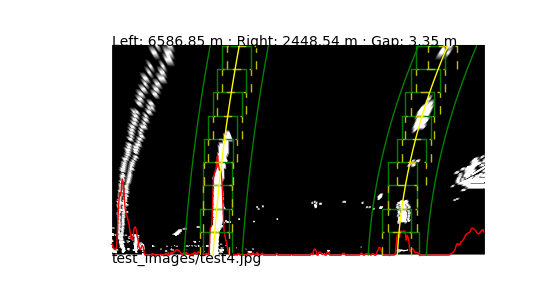

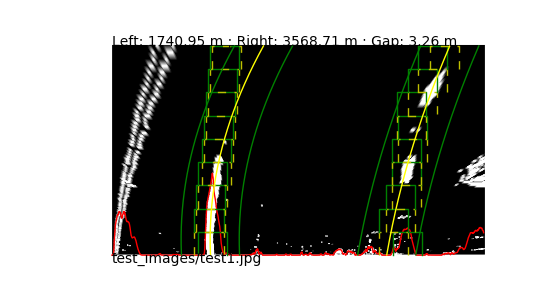

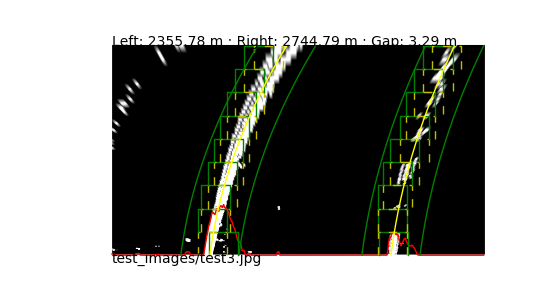

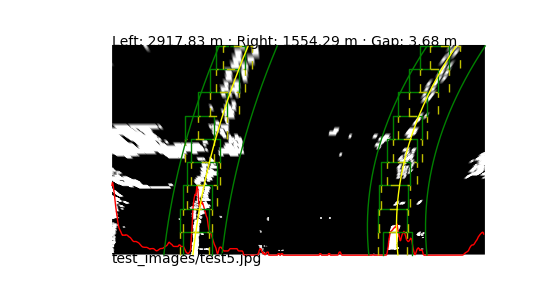

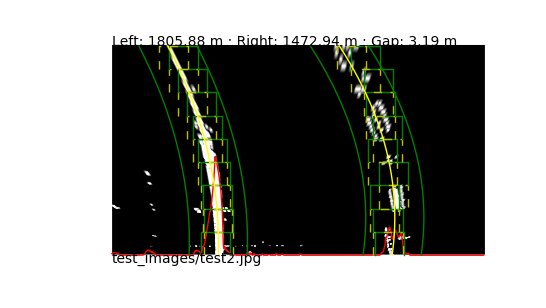

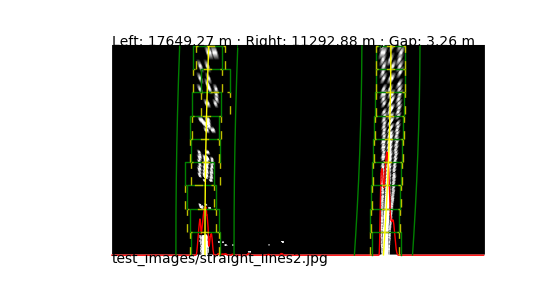

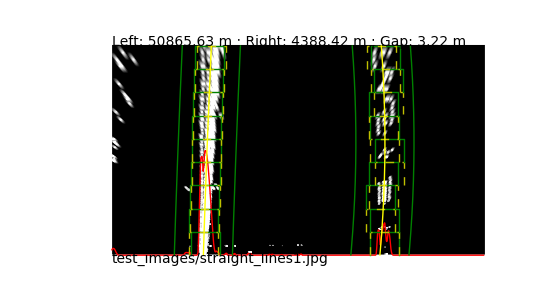

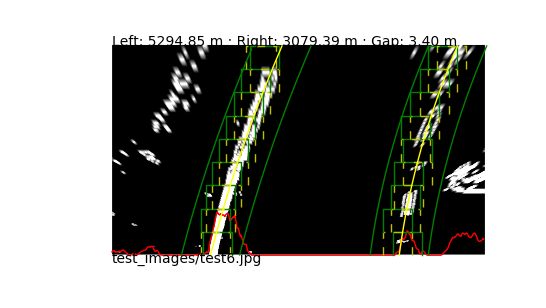

In [7]:
y_eval = 720

def calcCurve(data, scale=(xm_per_pix, ym_per_pix)):
    left_fit = data['leftLanePolynomial']
    right_fit = data['rightLanePolynomial']
    left_curve_rad = ((1 + (2*left_fit[0]*y_eval*scale[1] + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curve_rad = ((1 + (2*right_fit[0]*y_eval*scale[1] + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    data['leftLaneCurvature'] = left_curve_rad
    data['rightLaneCurvature'] = right_curve_rad

def computeGap(data, scale=(xm_per_pix, ym_per_pix)):
    left_fit = data['leftLanePolynomial']
    right_fit = data['rightLanePolynomial']
    fity = np.arange(619,719)
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    data['laneGapPixels'] = np.average(fit_rightx-fit_leftx)
    data['laneGap'] = data['laneGapPixels'] * xm_per_pix

    
for fname in images:
    img = loadImage(fname)
    data = {}
    fitLanes(img, data, fname, visualize=True)
    calcCurve(data)
    computeGap(data)
    
    plt.text(0,0,"Left: %.2f m ; Right: %.2f m ; Gap: %.2f m"%(data['leftLaneCurvature'], data['rightLaneCurvature'], data['laneGap']))
    

Finished sample

Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.
The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.

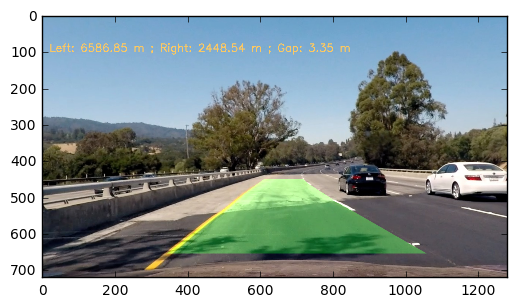

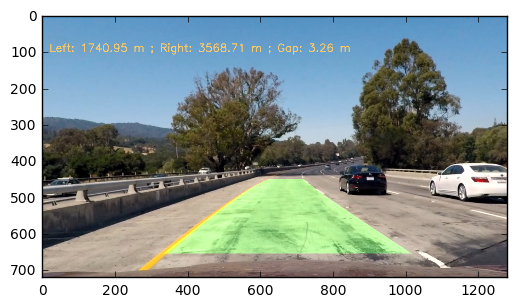

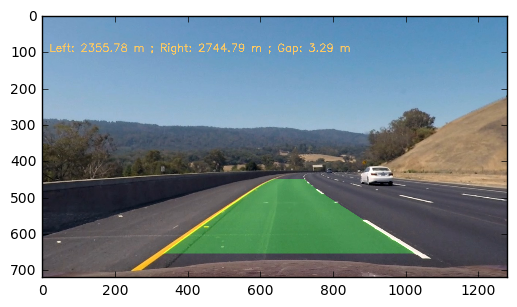

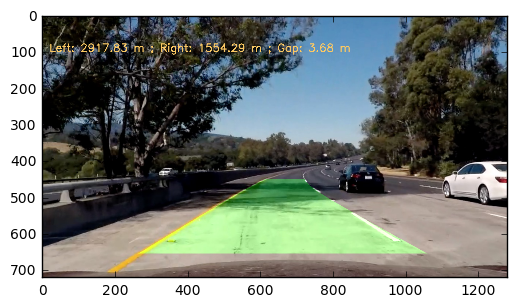

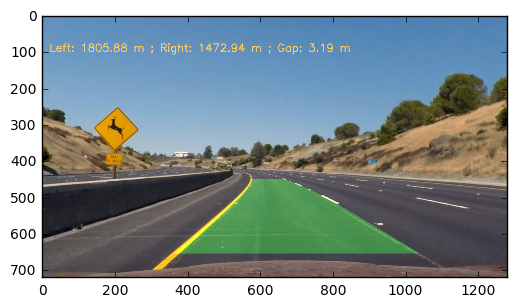

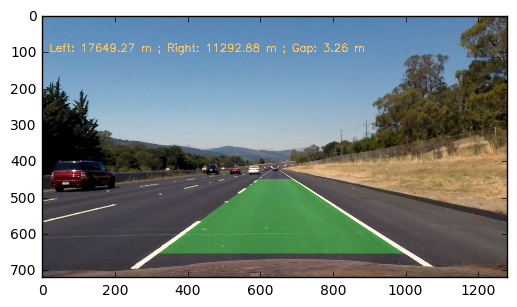

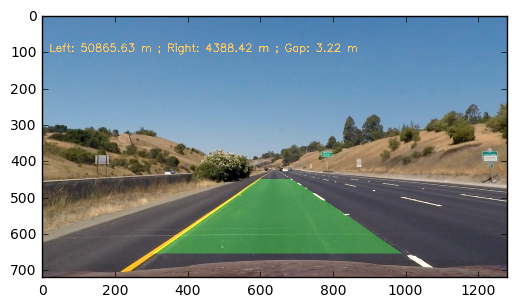

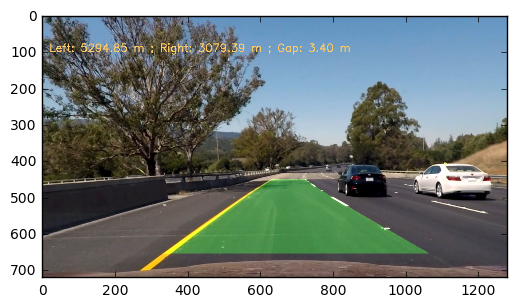

In [8]:
def stampText(img, txt):
    cv2.putText(img, txt, (20,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (250,200,100), 2)

def augmentImage(data):
    ploty, left_fitx, right_fitx = computeFitLines(0, data['birdsEyeViewImage'].shape[0], data)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(data['birdsEyeViewImage']).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    undist = data['undistortedImage']
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    stampText(result, "Left: %.2f m ; Right: %.2f m ; Gap: %.2f m"%(data['leftLaneCurvature'], data['rightLaneCurvature'], data['laneGap']))

    data['augmentedImage'] = result
    
for fname in images:
    img = loadImage(fname)
    data = {}
    fitLanes(img, data, fname)
    calcCurve(data)
    computeGap(data)
    augmentImage(data)
    plt.figure()
    plt.imshow(data['augmentedImage'])


Pipeline for video

Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)
The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project. 

In [9]:
data={'haveLines': False}

def processImage(img):
    global data
    
    birdsEyeView(img, data)    

    if data['haveLines']:
        continueLaneFit(data)
        computeGap(data)
        # Sanity check
        if data['laneGapPixels'] < 600 or data['laneGapPixels'] > 700 :
            data['haveLines'] = False

    if not data['haveLines']:
        traceLaneEdges(data)
        computeGap(data)
        data['haveLines'] = True

    calcCurve(data)

    augmentImage(data)
    
    return data['augmentedImage']

clip1 = VideoFileClip("project_video.mp4")
modifiedClip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time modifiedClip.write_videofile('project_video.out.mp4', audio=False)



[MoviePy] >>>> Building video project_video.out.mp4
[MoviePy] Writing video project_video.out.mp4


100%|█████████▉| 1260/1261 [03:15<00:00,  6.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.out.mp4 

CPU times: user 24min 26s, sys: 7.5 s, total: 24min 34s
Wall time: 3min 16s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video.out.mp4'))

Discussion

Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?
Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail. 